In [1]:
import os
import sys
import shutil
import argparse
import IPython 
from PIL import Image
from enum import Enum
from typing import Callable, List, Optional, Tuple, Union
from functools import partial

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import VisionDataset
from torchvision.transforms import transforms
import numpy as np
import pandas as pd
import skimage
from scipy import sparse
import matplotlib.pyplot as plt 
import torchxrayvision as xrv

from dinov2.models.unet import UNet
from dinov2.data import SamplerType, make_data_loader, make_dataset
from dinov2.data.datasets import NIHChestXray, MC
from dinov2.data.loaders import make_data_loader
from dinov2.data.transforms import make_xray_classification_eval_transform, make_classification_eval_transform, make_segmentation_target_transform
from dinov2.eval.setup import setup_and_build_model
from dinov2.eval.utils import ModelWithIntermediateLayers, ModelWithNormalize, evaluate, extract_features
from dinov2.eval.metrics import build_multiclass_segmentation_metrics
from dinov2.utils import show_image_from_tensor

In [2]:
args = argparse.Namespace(config_file='dinov2/configs/eval/vits14_pretrain.yaml', pretrained_weights='models/dinov2_vits14_pretrain.pth', output_dir='results/NIH/dinov2_vits14/knn', opts=[], train_dataset_str='MC:split=TRAIN:root=/mnt/z/data/MC/train', val_dataset_str='MC:split=VAL:root=/mnt/z/data/MC/test', nb_knn=[5, 20, 50, 100, 200], temperature=0.07, gather_on_cpu=False, batch_size=8, n_per_class_list=[-1], n_tries=1, ngpus=1, nodes=1, timeout=2800, partition='learnlab', use_volta32=False, comment='', exclude='')
model, autocast_dtype = setup_and_build_model(args)
# model = ModelWithNormalize(model)

I20230826 03:50:03 19871 dinov2 config.py:60] git:
  sha: 7fa2ff155139af8fd753ef099cf8e0a0c0cd1e01, status: has uncommitted changes, branch: main

I20230826 03:50:03 19871 dinov2 config.py:61] batch_size: 8
comment: 
config_file: dinov2/configs/eval/vits14_pretrain.yaml
exclude: 
gather_on_cpu: False
n_per_class_list: [-1]
n_tries: 1
nb_knn: [5, 20, 50, 100, 200]
ngpus: 1
nodes: 1
opts: ['train.output_dir=/mnt/c/Users/user/Desktop/dinov2/results/NIH/dinov2_vits14/knn']
output_dir: /mnt/c/Users/user/Desktop/dinov2/results/NIH/dinov2_vits14/knn
partition: learnlab
pretrained_weights: models/dinov2_vits14_pretrain.pth
temperature: 0.07
timeout: 2800
train_dataset_str: MC:split=TRAIN:root=/mnt/z/data/MC/train
use_volta32: False
val_dataset_str: MC:split=VAL:root=/mnt/z/data/MC/test
I20230826 03:50:03 19871 dinov2 config.py:27] sqrt scaling learning rate; base: 0.004, new: 0.001
I20230826 03:50:03 19871 dinov2 config.py:34] MODEL:
  WEIGHTS: ''
compute_precision:
  grad_scaler: true
  teach

In [31]:
# root_location = "/mnt/z/data/MC"
# images_location = root_location + os.sep + "CXR_png"
# images = os.listdir(images_location)
# test_indices = range(0, len(images), 3)
# train_indices = [i for i in range(len(images)) if i not in test_indices]
# for image_index in test_indices:
#     prev_loc = images_location + os.sep + images[image_index]
#     new_loc = root_location + os.sep + "test"
#     shutil.copy(prev_loc, new_loc)

# for image_index in train_indices:
#     prev_loc = images_location + os.sep + images[image_index]
#     new_loc = root_location + os.sep + "train"
#     shutil.copy(prev_loc, new_loc)

In [3]:
train_dataset_str = args.train_dataset_str
val_dataset_str = args.val_dataset_str
batch_size = args.batch_size
gather_on_cpu = args.gather_on_cpu
num_workers = 1

In [4]:
transform = make_classification_eval_transform(resize_size=448, crop_size=448)
target_transform = make_segmentation_target_transform(resize_size=448)

train_dataset = make_dataset(
    dataset_str=args.train_dataset_str,
    transform=transform,
    target_transform=target_transform
)
val_dataset = make_dataset(
    dataset_str=args.val_dataset_str,
    transform=transform,
    target_transform=target_transform,
)

sampler_type = SamplerType.INFINITE

train_data_loader = make_data_loader(
    dataset=train_dataset,
    batch_size=2,
    num_workers=1,
    shuffle=True,
    seed=0,
    sampler_type=sampler_type,
    sampler_advance=1,
    drop_last=False,
    persistent_workers=True,
)

I20230826 03:50:10 19871 dinov2 loaders.py:90] using dataset: "MC:split=TRAIN:root=/mnt/z/data/MC/train"
46 scans are missing from TRAIN set
I20230826 03:50:10 19871 dinov2 loaders.py:95] # of dataset samples: 92
I20230826 03:50:10 19871 dinov2 loaders.py:90] using dataset: "MC:split=VAL:root=/mnt/z/data/MC/test"
92 scans are missing from VAL set
I20230826 03:50:10 19871 dinov2 loaders.py:95] # of dataset samples: 46
I20230826 03:50:10 19871 dinov2 loaders.py:118] sampler: infinite
I20230826 03:50:10 19871 dinov2 loaders.py:212] using PyTorch data loader
I20230826 03:50:10 19871 dinov2 loaders.py:227] infinite data loader


In [5]:
class LinearDecoder(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearDecoder, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.decoder = torch.nn.Conv2d(in_channels, num_labels, (1,1))
        self.decoder.weight.data.normal_(mean=0.0, std=0.01)
        self.decoder.bias.data.zero_()

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.decoder(embeddings)

In [6]:
decoder = LinearDecoder(384, num_labels=3).cuda()
optimizer = torch.optim.SGD(params=decoder.parameters(), lr=0.0005, momentum=0.9, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 69, eta_min=0)

In [7]:
class MetricAveraging(Enum):
    MEAN_ACCURACY = "micro"
    MEAN_PER_CLASS_ACCURACY = "macro"
    MULTILABEL_ACCURACY = "macro"
    MULTILABEL_AUROC = "macro"
    MULTILABEL_JACCARD = "macro"
    PER_CLASS_ACCURACY = "none"

    def __str__(self):
        return self.value

metric = build_multiclass_segmentation_metrics(average_type=MetricAveraging.MULTILABEL_JACCARD,num_labels=3)
metric.cuda()

MetricCollection(
  (dice): Dice()
  (jaccard): MulticlassJaccardIndex()
)

{'dice': tensor(0.1401, device='cuda:0'), 'jaccard': tensor(0.2528, device='cuda:0')}
1.2080132961273193


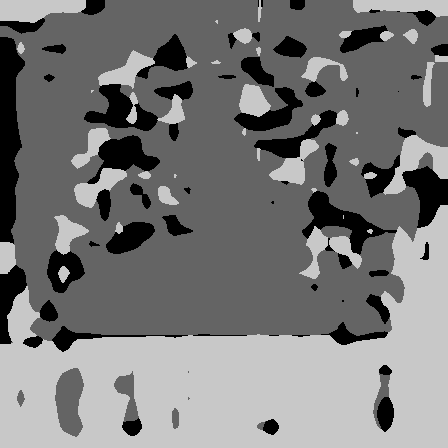

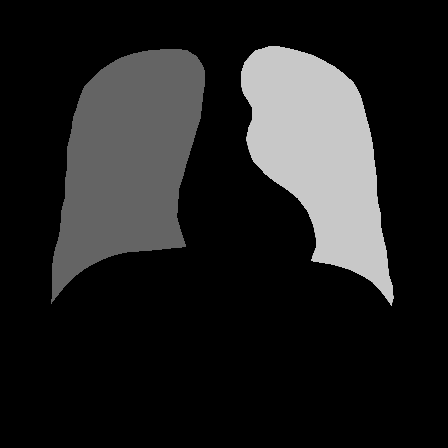

{'dice': tensor(0.1194, device='cuda:0'), 'jaccard': tensor(0.1653, device='cuda:0')}
0.9873137474060059


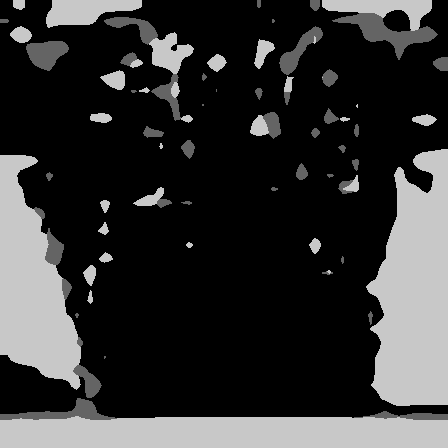

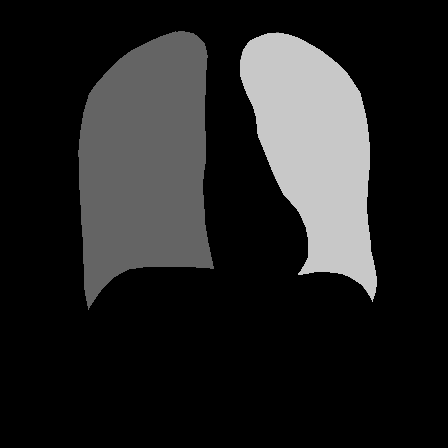

{'dice': tensor(0.1028, device='cuda:0'), 'jaccard': tensor(0.1187, device='cuda:0')}
0.8036055564880371


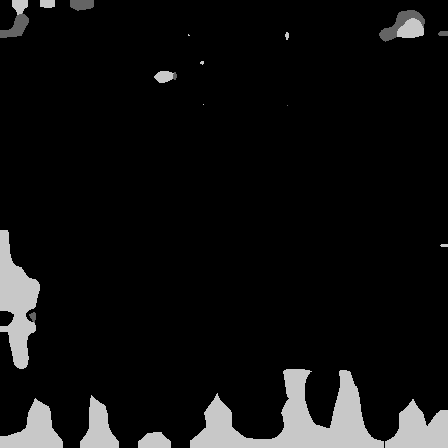

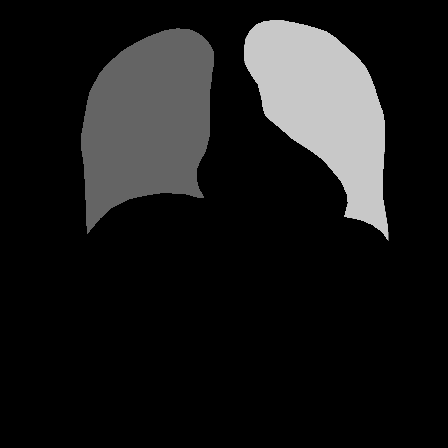

{'dice': tensor(0.0907, device='cuda:0'), 'jaccard': tensor(0.0912, device='cuda:0')}
0.8534814715385437


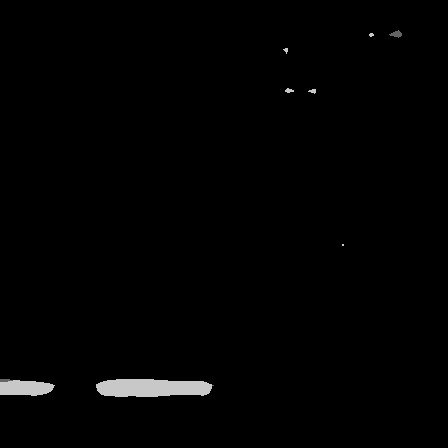

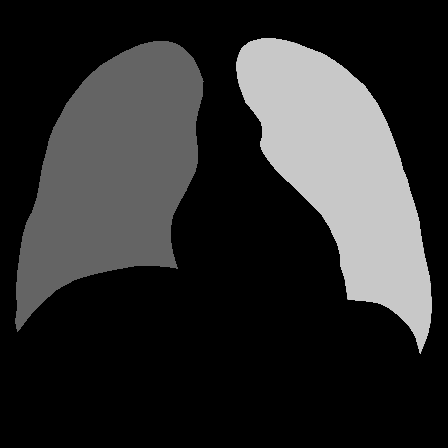

{'dice': tensor(0.0820, device='cuda:0'), 'jaccard': tensor(0.0753, device='cuda:0')}
0.8499465584754944


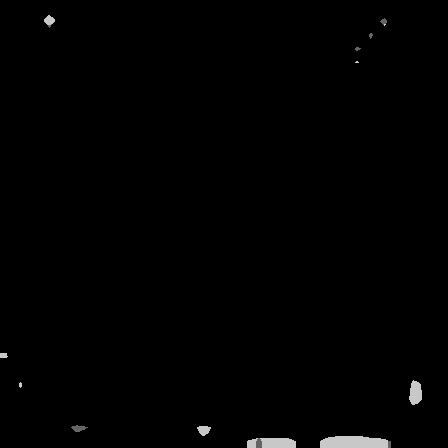

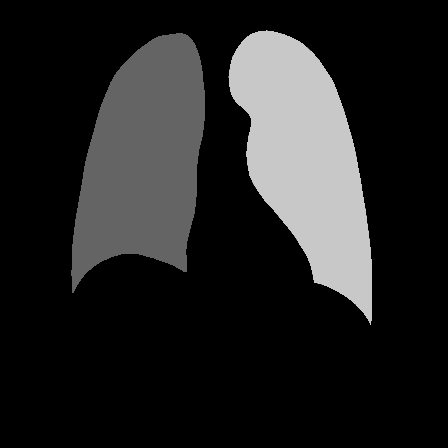

{'dice': tensor(0.0744, device='cuda:0'), 'jaccard': tensor(0.0639, device='cuda:0')}
0.8267806768417358


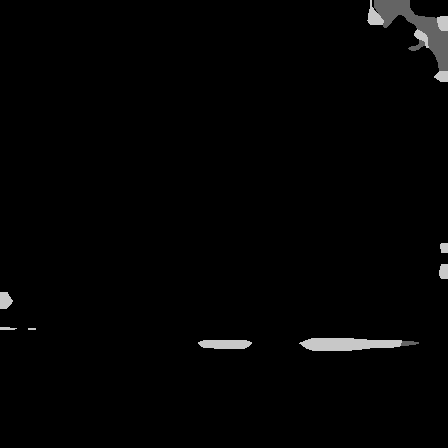

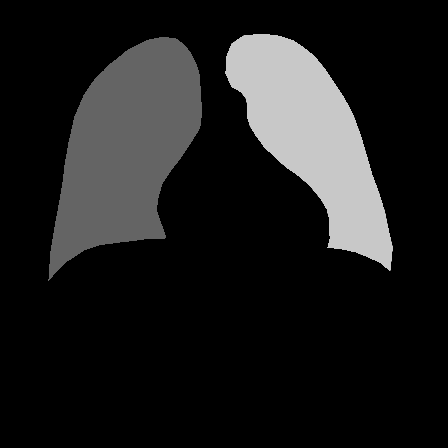

{'dice': tensor(0.0700, device='cuda:0'), 'jaccard': tensor(0.0578, device='cuda:0')}
0.529894232749939


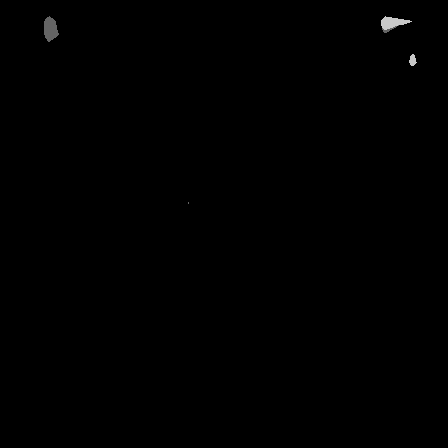

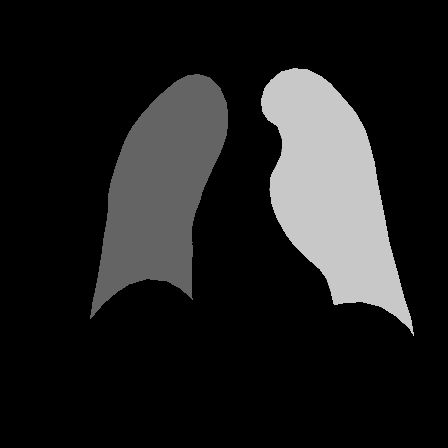

{'dice': tensor(0.0663, device='cuda:0'), 'jaccard': tensor(0.0529, device='cuda:0')}
0.5507751107215881


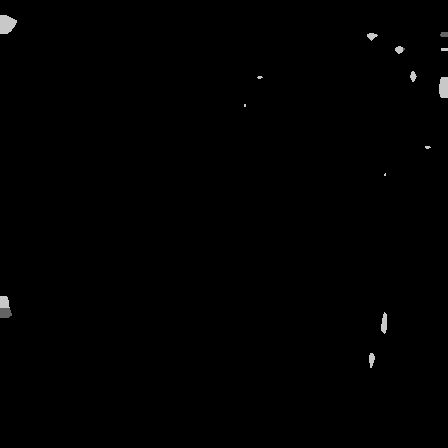

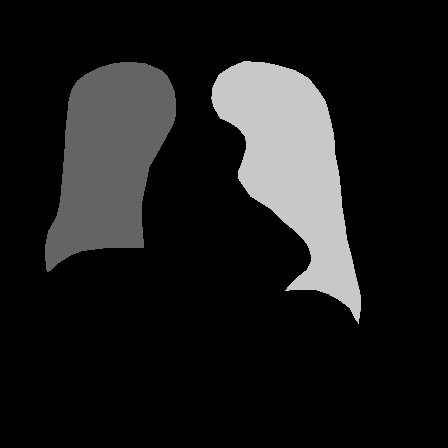

{'dice': tensor(0.0625, device='cuda:0'), 'jaccard': tensor(0.0478, device='cuda:0')}
0.6807543635368347


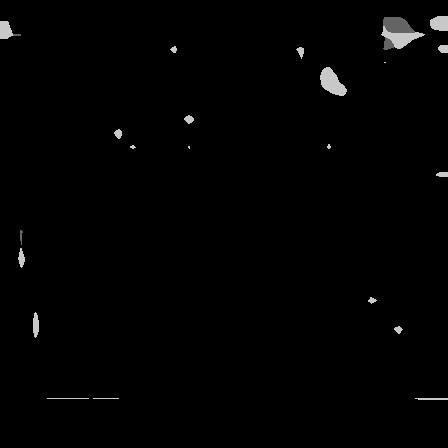

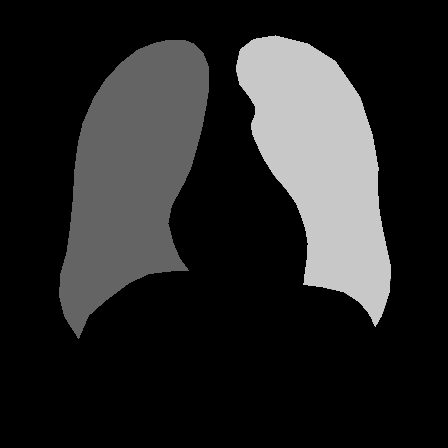

{'dice': tensor(0.0606, device='cuda:0'), 'jaccard': tensor(0.0451, device='cuda:0')}
0.5806305408477783


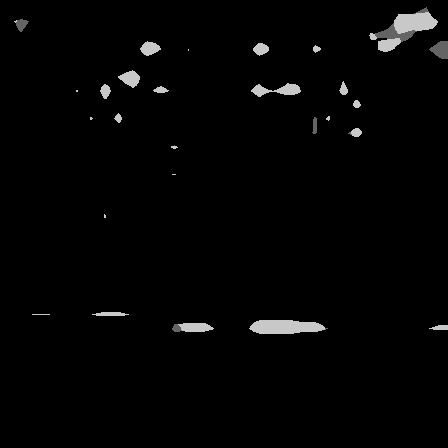

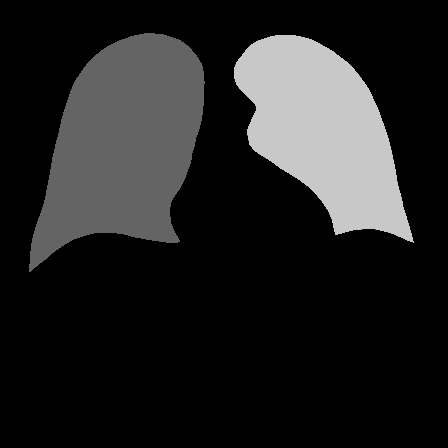

{'dice': tensor(0.0602, device='cuda:0'), 'jaccard': tensor(0.0437, device='cuda:0')}
0.7046829462051392


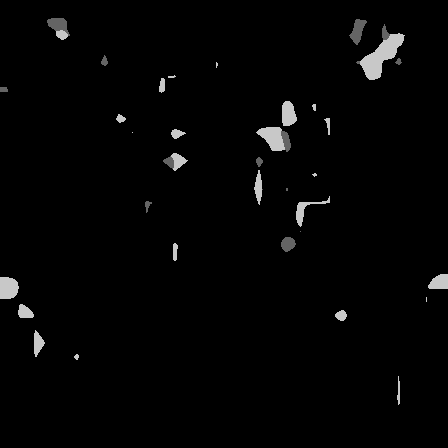

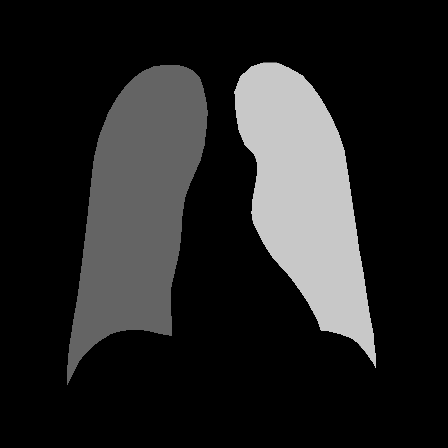

{'dice': tensor(0.0587, device='cuda:0'), 'jaccard': tensor(0.0415, device='cuda:0')}
0.7189509272575378


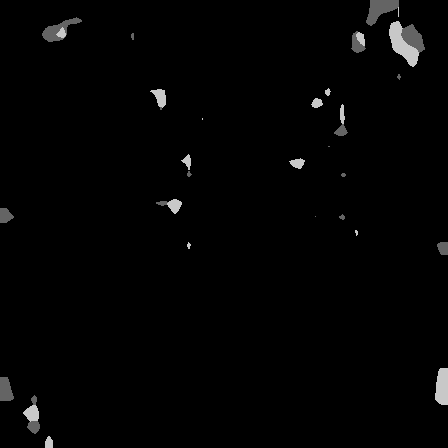

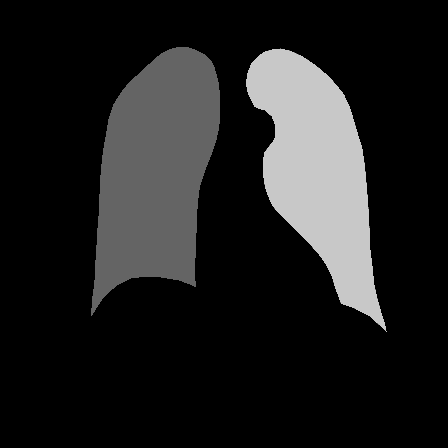

{'dice': tensor(0.0560, device='cuda:0'), 'jaccard': tensor(0.0387, device='cuda:0')}
0.7144646048545837


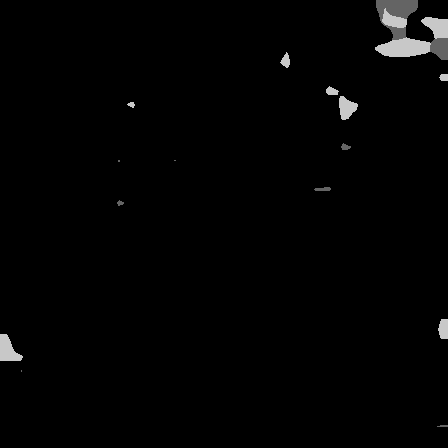

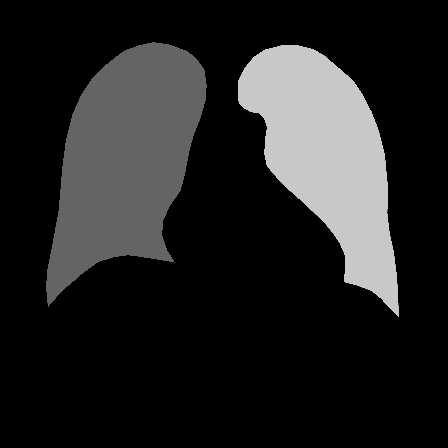

{'dice': tensor(0.0528, device='cuda:0'), 'jaccard': tensor(0.0357, device='cuda:0')}
0.6743520498275757


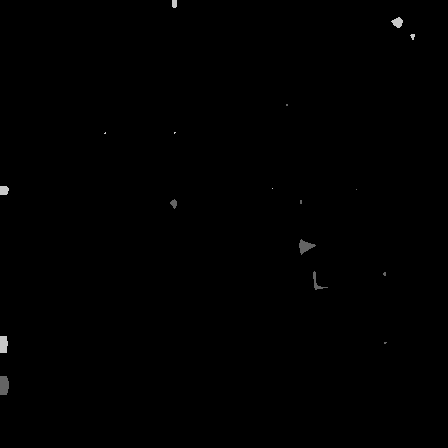

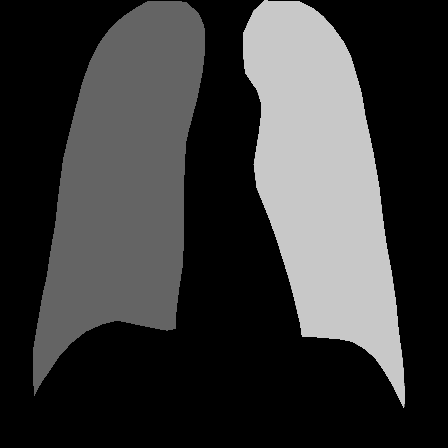

KeyboardInterrupt: 

In [8]:
i = 0
for image, target in train_data_loader:
    i+=1
    image, target = image.cuda(non_blocking=True), target.cuda(non_blocking=True)
    with torch.no_grad(): 
        features=model.forward_features(image)['x_norm_patchtokens']
    logits = decoder(features)
    logits = torch.nn.functional.interpolate(logits, size=448, mode="bilinear", align_corners=False)
    prediction = logits.argmax(dim=1)

    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(logits, target)
    
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    scheduler.step()

    metric(prediction, target)
    print(metric.compute())
    print(loss.item())

    # if i % 50 == 0:
    show_image_from_tensor((prediction * 100).cpu())
    show_image_from_tensor((target * 100).cpu())